In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 13:53:38.236874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 13:53:39.034110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_ballad_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

401453


In [9]:
#txt_file = 'data/kor_dance_text.txt'
#txt_file = 'data/kor_folk_text.txt'
#txt_file = 'data/kor_hiphop_text.txt'
#txt_file = 'data/kor_indie_text.txt'
#txt_file = 'data/kor_rnb_text.txt'
#txt_file = 'data/kor_rock_text.txt'
txt_file = 'data/kor_trot_text.txt'
with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

2628957


In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿.,]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [12]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

1424007
['<start> dearest, darling, my universe <end>', '<start> 날 데려가 줄래? <end>', '<start> 나의 이 가난한 상상력으론 <end>', '<start> 떠올릴 수 없는 곳으로 <end>', '<start> 저기 멀리 from earth to mars <end>', '<start> 꼭 같이 가줄래? <end>', '<start> 그곳이 어디든, 오랜 외로움 <end>', '<start> 그 반대말을 찾아서 <end>', '<start> 어떤 실수로 <end>', '<start> 이토록 우리는 <end>']


In [13]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [14]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f433615a390> 
 [[    2     1 14767 ...     0     0     0]
 [    2     9  1796 ...     0     0     0]
 [    2    29    15 ...     0     0     0]
 ...
 [    2     6  1792 ...     0     0     0]
 [    2    15  1132 ...     0     0     0]
 [    2    99   706 ...     0     0     0]]


In [15]:
tensor.shape

(1424007, 35)

In [16]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : 내
7 : 난
8 : 그
9 : 날
10 : 수
11 : me
12 : 널
13 : 내가
14 : the
15 : 이
16 : my
17 : it
18 : 더
19 : 나
20 : love


In [17]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (1424007, 35)
소스문장 길이:  34
타겟문장 길이:  34


In [18]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (1139205, 34)
Target Train 길이:  (1139205, 34)
Source Test 길이:  (284802, 34)
Target Test 길이:  (284802, 34)


In [19]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 13:55:34.526069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 13:55:34.569869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 13:55:34.570072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 34), dtype=tf.int32, name=None), TensorSpec(shape=(256, 34), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 34), dtype=tf.int32, name=None), TensorSpec(shape=(256, 34), dtype=tf.int32, name=None))>


In [20]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [21]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [22]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 34, 30001), dtype=float32, numpy=
array([[[-0.00391585,  0.00919329, -0.00650095, ..., -0.00138284,
         -0.00180691, -0.00409862],
        [-0.00779051,  0.00438858, -0.01630272, ..., -0.00706884,
         -0.00484543,  0.0039979 ],
        [-0.02692492, -0.00376099, -0.01312265, ...,  0.02165227,
          0.01834047, -0.00406765],
        ...,
        [-0.00812577, -0.02824927,  0.10710732, ...,  0.01515473,
         -0.05788318,  0.04143272],
        [-0.00266775, -0.01668555,  0.02818009, ..., -0.05397904,
         -0.03030639,  0.13396245],
        [ 0.02837178, -0.01459016,  0.05817924, ..., -0.00108734,
         -0.07686722,  0.0121779 ]],

       [[-0.00391585,  0.00919329, -0.00650095, ..., -0.00138284,
         -0.00180691, -0.00409862],
        [-0.0199952 ,  0.00227346, -0.01333596, ..., -0.0042873 ,
         -0.01166827, -0.00617074],
        [-0.01377997, -0.0068656 , -0.00235286, ...,  0.02592991,
          0.0230179 , -0.00404037],
        .

In [23]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [26]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712930158.267419  518400 service.cc:145] XLA service 0x36ac3120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712930158.267473  518400 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 13:55:58.317186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 13:55:58.833212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712930159.740994  518468 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712930159.764442  518469 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 1748 bytes spill stores, 2168 bytes spill loads

I0000 00:00:1712930160.

4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1976s 442ms/step - loss: 1.0037
Epoch 2/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1962s 440ms/step - loss: 0.7234
Epoch 3/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1960s 440ms/step - loss: 0.6663
Epoch 4/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1959s 440ms/step - loss: 0.6393
Epoch 5/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1960s 440ms/step - loss: 0.6241
Epoch 6/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1960s 440ms/step - loss: 0.6141
Epoch 7/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1961s 440ms/step - loss: 0.6089
Epoch 8/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1960s 440ms/step - loss: 0.6071
Epoch 9/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1959s 440ms/step - loss: 0.6087
Epoch 10/10
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 1960s 440ms/step - loss: 0.6131


In [27]:
model.save('rnn_kor.keras')
model.save('rnn_kor.h5')
tf.saved_model.save(model, 'rnn_kor.tf')

INFO:tensorflow:Assets written to: rnn_kor.tf/assets


INFO:tensorflow:Assets written to: rnn_kor.tf/assets


In [28]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [29]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i don t wanna be alone <end> '

In [30]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 이제 가노라 <end> '

In [31]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 이제 가노라 <end> '

In [32]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 사랑해 사랑해 <end> '

In [33]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 <unk> <end> '

In [34]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 <unk> <end> '

In [35]:
youth = ['so', '네', '마음', '조금은', '이상한', '네게', '너의', '피어오른', '크기를', 'i']
for word in youth:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> so i can stand on mountains <end> 
<start> 네 곁에 있을게 <end> 
<start> 마음 깊은 곳에서 <end> 
<start> 조금은 어설프게 <unk> <end> 
<start> 이상한 <unk> <end> 
<start> 네게 <unk> <end> 
<start> 너의 <unk> <unk> <end> 
<start> 피어오른 <unk> <end> 
<start> <unk> <unk> <end> 
<start> i don t wanna be alone <end> 


In [36]:
carol = ['이레', '이', '겨울', '저', '이번', 'ng', '흩날리는', '쌓였던', '따스한', '눈부신']
for word in carol:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> <unk> <unk> <end> 
<start> 이 <unk> <unk> <end> 
<start> 겨울 앞에서 <end> 
<start> 저 <unk> <unk> <end> 
<start> 이번 여름 <unk> <end> 


<start> ng li <unk> <unk> ni mi <unk> <end> 
<start> 흩날리는 벚꽃잎이 <end> 
<start> 쌓였던 아쉬움을 <unk> <end> 
<start> 따스한 <unk> <end> 
<start> 눈부신 너의 <unk> <end> 


In [37]:
little_girl = ['i', '남', '작업', '안', 'real', '난', '그녀는', '랩', '쌘', '너랑', '더', 'ice', '계속', '이젠', '너가']
for word in little_girl:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> i don t wanna be alone <end> 
<start> 남 몰래 숨어서 혼자 울고 <end> 
<start> 작업 때려 <unk> <end> 
<start> 안 치게 될 거야 <end> 
<start> real life <end> 
<start> 난 <unk> <unk> <end> 
<start> 그녀는 나의 <unk> <end> 
<start> 랩 빼곤 <unk> <end> 
<start> <unk> <unk> <end> 
<start> 너랑 나랑 있고 싶어서 <end> 
<start> 더 <unk> <end> 
<start> ice cream chillin <end> 
<start> 계속 <unk> <end> 
<start> 이젠 <unk> <end> 
<start> 너가 <unk> <end> 


In [38]:
butterfly = ['날', '이것만으론', '어디든', '망설이다', '괜히', '난', '네가', '헷갈리게', 'dont', '스쳐']
for word in butterfly:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 날 <unk> <end> 
<start> <unk> <unk> <end> 
<start> 어디든 갈 곳을 향해 <end> 
<start> 망설이다 <unk> <end> 
<start> 괜히 <unk> 바라봤어 <end> 
<start> 난 <unk> <unk> <end> 
<start> 네가 <unk> <end> 
<start> 헷갈리게 하지 마 <end> 
<start> dont wanna waste time <end> 
<start> 스쳐 가는 인연 중에 <end> 


In [39]:
exit = ['어떤', '그날', '어디로', '나', '달력에', '지울', '기대', '입김', '내', '많이']
for word in exit:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 어떤 <unk> 가능해 <end> 
<start> 그날 이후 <end> 
<start> 어디로 가야 하죠 <end> 
<start> 나 이제 가노라 <end> 
<start> 달력에 <unk> 빨갛게 <end> 
<start> 지울 수 없는 <unk> <end> 
<start> 기대 누워 잠들고 싶어 <end> 
<start> 입김 <unk> <end> 
<start> 내 <unk> <unk> <end> 
<start> 많이 <unk> 했었어 <end> 


In [40]:
tommorow = ['영화', '생각이', '괜찮을', '도망', '내일은', '매일', '시선을', '어떡할까', '허락', '점점']
for word in tommorow:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 영화 같은 <unk> 끝에 <end> 
<start> 생각이 나겠지만 <end> 
<start> 괜찮을 것 같다는 <end> 
<start> 도망 간대도 <end> 
<start> 내일은 해가 뜬다 <end> 
<start> 매일 밤 <end> 
<start> 시선을 벗어나는 빛 <end> 
<start> 어떡할까 <end> 
<start> 허락 없이 말없이 가 <end> 
<start> 점점 더 가까워질수록 <end> 


In [41]:
jewel = ['사랑이란', '여자도', '운명처럼', '내사랑은', '동쪽에', '황혼이', '영원히', '행복']
for word in jewel:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 사랑이란 건 <end> 
<start> 여자도 올라가는 <unk> <end> 
<start> 운명처럼 다시 만나면 <end> 
<start> 내사랑은 항상 그대 뿐이죠 <end> 
<start> <unk> <unk> <end> 
<start> 황혼이 <unk> <end> 
<start> 영원히 <unk> <end> 
<start> 행복 이제는 <unk> <end> 


all genre_임수-goood  
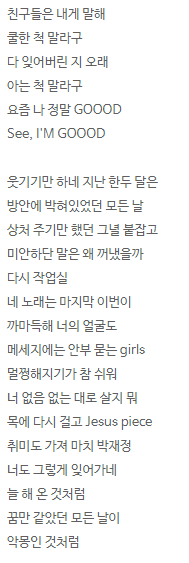

In [42]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 내게 <unk> 허 <end> 
<start> 쿨한 이별이 될 것 같아 <end> 


<start> 다 <unk> <end> 
<start> 아는 <unk> <end> 
<start> 요즘 내 하루는 <unk> 어쩌라고 <end> 
<start> see you on facetime <end> 
<start> <unk> <unk> <end> 
<start> 방안에 덩그러니 <end> 
<start> 상처 주는 건 왜 발이 <unk> <end> 
<start> 미안하단 말조차 못했는데 <end> 


: 